# 0. CONFIGURATION

In [1]:
# data config
data_path = "data/data.csv"
unnecessary_cols = ['nameOrig', 'nameDest', 'isFlaggedFraud', 'step']

In [2]:
# params
RANDOM_STATE = 42
TEST_SIZE = 0.2

In [3]:
# model path to save
model_path = "artefacts/catboost_model.joblib"
scaler_path = "artefacts/scaler.joblib"

# 1. MODULES

In [4]:
import shap 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score

import joblib
import warnings
warnings.filterwarnings("ignore")

# 2. MAIN

## 2.1 DATA PREPARATION

In [5]:
# read dataset
data = pd.read_csv(data_path)
data.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
# drop unnecessary columns
data.drop(unnecessary_cols, axis=1, inplace=True)

In [7]:
# encode categorical variable
label_encoder = LabelEncoder()
data['type'] = label_encoder.fit_transform(data['type'])

for index, label in enumerate(label_encoder.classes_):
    print(f"Encoded value {index} -> Class: {label}")

Encoded value 0 -> Class: CASH_IN
Encoded value 1 -> Class: CASH_OUT
Encoded value 2 -> Class: DEBIT
Encoded value 3 -> Class: PAYMENT
Encoded value 4 -> Class: TRANSFER


In [8]:
# split data into features (X) and target (y)
X = data.drop(['isFraud'], axis = 1)
y = data['isFraud']

# scale into one dimension
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [9]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE, 
    shuffle = True)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (80000, 6)
X_test shape: (20000, 6)
y_train shape: (80000,)
y_test shape: (20000,)


In [10]:
# Convert the data to CatBoost Pool format
train_data = Pool(X_train, label=y_train)
test_data = Pool(X_test, label=y_test)

## 2.2 MODEL TRAINING

In [11]:
model = CatBoostClassifier(
    iterations = 500,
    learning_rate = 0.01,
    depth = 5,
    verbose=False
)

model.fit(train_data)

## 2.3 MODEL EVALUATION

In [12]:
# check the performance
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f'Accuracy Score : {acc * 100 : .2f}%')

roc = roc_auc_score(y_test, y_pred)
print(f'AUC ROC : {roc * 100 : .2f} %')

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy Score :  99.95%
AUC ROC :  77.27 %
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19978
           1       1.00      0.55      0.71        22

    accuracy                           1.00     20000
   macro avg       1.00      0.77      0.85     20000
weighted avg       1.00      1.00      1.00     20000



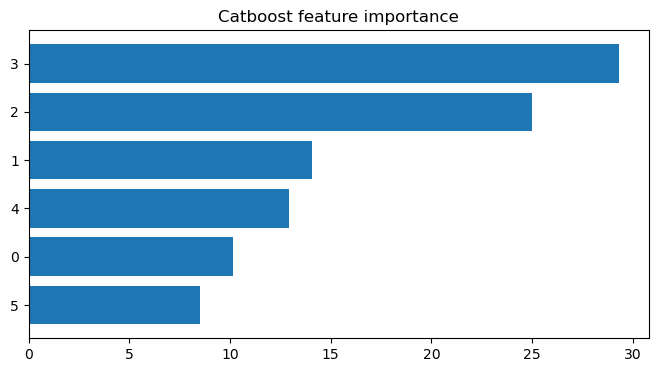

In [13]:
# let's look at the importance of the features
feature_importance = model.feature_importances_
feature_names = model.feature_names_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(8, 4))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.title('Catboost feature importance')
plt.show()

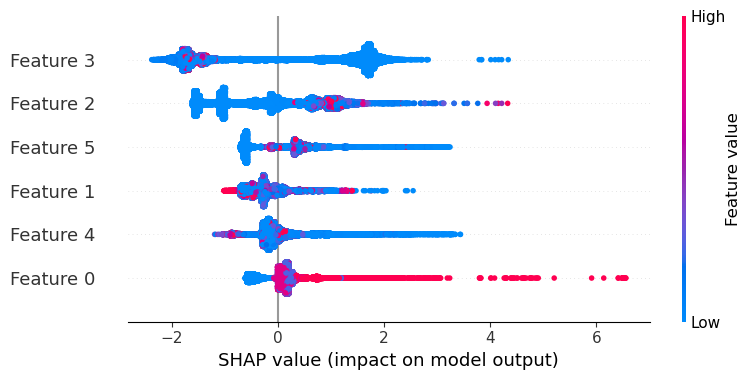

In [14]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

## 2.4 SAVE MODEL

In [15]:
with open(model_path, 'wb') as file:
    joblib.dump(model, file)

with open(scaler_path, 'wb') as file:
    joblib.dump(scaler, file)

print(f"Model training complete and saved as {model_path}")
print(f"Scaler complete and saved as {scaler_path}")

Model training complete and saved as artefacts/catboost_model.joblib
Scaler complete and saved as artefacts/scaler.joblib
